# Estimación y/o eliminación de la componente estacional del consumo de energía de PJM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression  # solo uso esta en la reg lineal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
import scipy as sp
import scipy.stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import STL
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import numpy as np
import sklearn


## Carga de los datos. 

In [2]:
import os
os.chdir("C:\\Users\\soffy\\OneDrive\\Escritorio\\Universidad\\Series_Tiempo")

In [3]:
# Cargar el archivo CSV
energia = pd.read_csv("energia.csv")
print(energia)

           fecha  Energia
0     2004-10-01   254046
1     2004-10-02   318280
2     2004-10-03   293620
3     2004-10-04   333971
4     2004-10-05   347423
...          ...      ...
5049  2018-07-29   326291
5050  2018-07-30   362481
5051  2018-07-31   367135
5052  2018-08-01   363979
5053  2018-08-02   371807

[5054 rows x 2 columns]


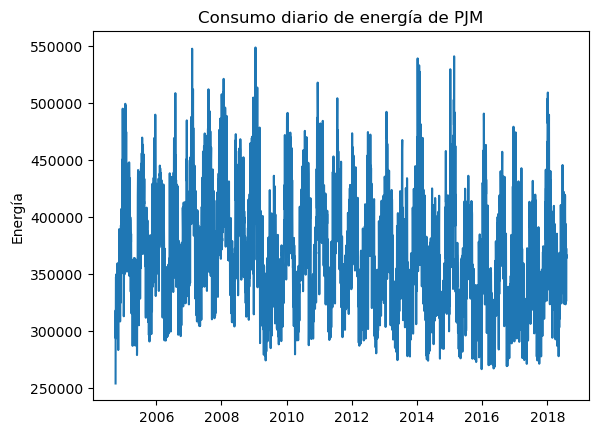

In [4]:
energia['fecha']=pd.to_datetime(energia['fecha']) # pasar a formato fecha
Valores_energia=energia.set_index('fecha') # nuevo dataframe indexado por la fecha
Valores_energia['Energia'] = pd.to_numeric(Valores_energia['Energia'], errors='coerce')
energia_ts=Valores_energia['Energia'] # vector con los valores de la serie

plt.plot(energia_ts)
plt.title('Consumo diario de energía de PJM')
plt.ylabel('Energía')
plt.show()

In [5]:
indice = pd.date_range(start='1/1/2004', periods=5054, freq='D')
indice
energiats =pd.Series(energia['Energia'].values,index=indice)
energiadf =pd.DataFrame(energia['Energia'].values,index=indice)

Ahora procederemos a estimar el ciclo estacional que se observa en esta serie de tiempo, es importante resaltar que con ayuda de los graficos exploratorios y el periodograma se observo que el periodo de la componente estacional es $s=183$, por lo tanto utilizaremos en primer lugar componentes de fourier, esto teniendo en cuenta que se aprecia que la componente estacional sigue un comportamiento deterministico y posiblemente sinosoidal.
Teniendo lo anterior en cuenta el modelo viene dado por:
$$\begin{align*}
x_t&=  ∑_{i=1}^k a_icos(k𝜔t)+b_isen(k𝜔t) + w_t \\
\end{align*}$$
Donde $k$ corresponderá al orden de la expansión en series de Fourier y los coeficientes $a_i$ y $b_i$ con $i=1,...,k$ serán estimados a través del método de mínimos cuadrados. El cálculo de esta componente se muestra a continuación considerando un orden $k=3$. 

In [6]:
frec_ang=(2*np.pi/183) #w=2*pi/s
energia2=energia.copy()

#Fourier k=1 
energia2['Year sin'] = np.sin(np.arange(1,5055)*(1*frec_ang))
energia2['Year cos'] = np.cos(np.arange(1,5055)*(1*frec_ang))

# Fourier k=2 
energia2['Year sin2'] = np.sin(np.arange(1,5055)*(2*frec_ang))
energia2['Year cos2'] = np.cos(np.arange(1,5055)*(2*frec_ang))

# Fourier k=3
energia2['Year sin3'] = np.sin(np.arange(1,5055)*(3*frec_ang))
energia2['Year cos3'] = np.cos(np.arange(1,5055)*(3*frec_ang))

#plt.plot(np.array(energia2['Year sin'])[:13], color="red", label="k=1")
#plt.plot(np.array(energia2['Year cos'])[:13], color="red")

#plt.plot(np.array(energia2['Year sin2'])[:13], color="blue", label="k=2")
#plt.plot(np.array(energia2['Year cos2'])[:13], color="blue")

#plt.plot(np.array(energia2['Year sin3'])[:13], color="green", label="k=3")
#plt.plot(np.array(energia2['Year cos3'])[:13], color="green")

#plt.xlabel('Time [h]')
#plt.title('Time of year signal')
#plt.legend()

In [7]:
X=np.column_stack((np.ones(5054),energia2['Year cos'],energia2['Year sin'],energia2['Year cos2'],energia2['Year sin2'],energia2['Year cos3'],energia2['Year sin3']))
energiasola=energia2['Energia']
linmodel_ciclo = sm.OLS(energiasola, X)
results_ciclo = linmodel_ciclo.fit()
print(results_ciclo.summary())

                            OLS Regression Results                            
Dep. Variable:                Energia   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     452.5
Date:                Wed, 11 Oct 2023   Prob (F-statistic):               0.00
Time:                        06:43:32   Log-Likelihood:                -60487.
No. Observations:                5054   AIC:                         1.210e+05
Df Residuals:                    5047   BIC:                         1.210e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.72e+05    537.082    692.636      0.0

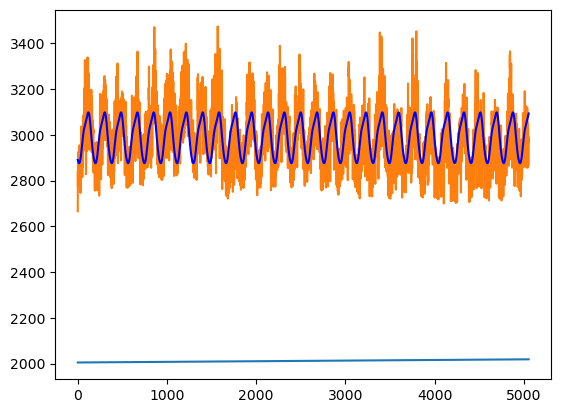

In [8]:
ypred = results_ciclo.predict(X)
energia2["predict estacion"] = ypred
plt.plot(energia)
plt.plot(energia2["predict estacion"], color="blue")
plt.show()


#plt.plot(energia2)
#plt.plot(results_ciclo.predict(X), color="blue")
#plt.show()

# Árboles de decisión

## Creación de variables rezagadas

In [23]:
from pandas import DataFrame

# reframe as supervised learning
# lag observation (t-1) is the input variable and t is the output variable.
df1 = DataFrame()
print(df1)

for i in range(3,0,-1):
    df1[['t-'+str(i)]] = energiadf.shift(i)
    
for i in range(185,182,-1):   
    df1[['t-'+str(i)]] = energiadf.shift(i)
print(df1)

Empty DataFrame
Columns: []
Index: []
                 t-3       t-2       t-1     t-185     t-184     t-183
2004-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2004-01-02       NaN       NaN  254046.0       NaN       NaN       NaN
2004-01-03       NaN  254046.0  318280.0       NaN       NaN       NaN
2004-01-04  254046.0  318280.0  293620.0       NaN       NaN       NaN
2004-01-05  318280.0  293620.0  333971.0       NaN       NaN       NaN
...              ...       ...       ...       ...       ...       ...
2017-10-28  393948.0  387510.0  345439.0  405313.0  399524.0  354508.0
2017-10-29  387510.0  345439.0  326291.0  399524.0  354508.0  323591.0
2017-10-30  345439.0  326291.0  362481.0  354508.0  323591.0  374247.0
2017-10-31  326291.0  362481.0  367135.0  323591.0  374247.0  424097.0
2017-11-01  362481.0  367135.0  363979.0  374247.0  424097.0  433127.0

[5054 rows x 6 columns]


In [24]:
# Create column t
df1['t'] = energiadf.values
print(df1.head(13))

                 t-3       t-2       t-1  t-185  t-184  t-183       t
2004-01-01       NaN       NaN       NaN    NaN    NaN    NaN  254046
2004-01-02       NaN       NaN  254046.0    NaN    NaN    NaN  318280
2004-01-03       NaN  254046.0  318280.0    NaN    NaN    NaN  293620
2004-01-04  254046.0  318280.0  293620.0    NaN    NaN    NaN  333971
2004-01-05  318280.0  293620.0  333971.0    NaN    NaN    NaN  347423
2004-01-06  293620.0  333971.0  347423.0    NaN    NaN    NaN  347392
2004-01-07  333971.0  347423.0  347392.0    NaN    NaN    NaN  345767
2004-01-08  347423.0  347392.0  345767.0    NaN    NaN    NaN  346574
2004-01-09  347392.0  345767.0  346574.0    NaN    NaN    NaN  316377
2004-01-10  345767.0  346574.0  316377.0    NaN    NaN    NaN  294234
2004-01-11  346574.0  316377.0  294234.0    NaN    NaN    NaN  334600
2004-01-12  316377.0  294234.0  334600.0    NaN    NaN    NaN  350135
2004-01-13  294234.0  334600.0  350135.0    NaN    NaN    NaN  346924


In [25]:
# Create a new subsetted dataframe, removing Nans from first 185 rows
df1_energia = df1[185:]
print(df1_energia)
df1_energia.size

                 t-3       t-2       t-1     t-185     t-184     t-183       t
2004-07-04  347446.0  346920.0  325007.0  254046.0  318280.0  293620.0  347524
2004-07-05  346920.0  325007.0  347524.0  318280.0  293620.0  333971.0  346334
2004-07-06  325007.0  347524.0  346334.0  293620.0  333971.0  347423.0  337384
2004-07-07  347524.0  346334.0  337384.0  333971.0  347423.0  347392.0  338827
2004-07-08  346334.0  337384.0  338827.0  347423.0  347392.0  345767.0  338807
...              ...       ...       ...       ...       ...       ...     ...
2017-10-28  393948.0  387510.0  345439.0  405313.0  399524.0  354508.0  326291
2017-10-29  387510.0  345439.0  326291.0  399524.0  354508.0  323591.0  362481
2017-10-30  345439.0  326291.0  362481.0  354508.0  323591.0  374247.0  367135
2017-10-31  326291.0  362481.0  367135.0  323591.0  374247.0  424097.0  363979
2017-11-01  362481.0  367135.0  363979.0  374247.0  424097.0  433127.0  371807

[4869 rows x 7 columns]


34083

## Partición de los datos

In [26]:
energiasplit = df1_energia.values
# split into lagged variables and original time series
X1= energiasplit[:, 0:-1]  # slice all rows and start with column 0 and go up to but not including the last column
y1 =energiasplit[:,-1]  # slice all rows and last column, essentially separating out 't' column

In [27]:
print(X1[0])
print(y1[0])

[347446. 346920. 325007. 254046. 318280. 293620.]
347524.0


In [28]:
Y1 = y1
print('Complete Observations for Target after Supervised configuration: %d' %len(Y1))
traintarget_size = int(len(Y1) * 0.70) 
valtarget_size = int(len(Y1) * 0.10)+1# Set split
testtarget_size = int(len(Y1) * 0.20)# Set split
print(traintarget_size,valtarget_size,testtarget_size)
print('Train + Validation + Test: %d' %(traintarget_size+valtarget_size+testtarget_size))

train_target, val_target,test_target = Y1[0:traintarget_size],Y1[(traintarget_size):(traintarget_size+valtarget_size)] ,Y1[(traintarget_size+valtarget_size):len(Y1)]

print('Observaciones respuesta: %d' % (len(Y1)))
print('Observaciones para entrenamiento: %d' % (len(train_target)))
print('Observaciones para validación: %d' % (len(val_target)))
print('Observaciones para prueba: %d' % (len(test_target)))

Complete Observations for Target after Supervised configuration: 4869
3408 487 973
Train + Validation + Test: 4868
Observaciones respuesta: 4869
Observaciones para entrenamiento: 3408
Observaciones para validación: 487
Observaciones para prueba: 974


In [29]:
trainfeature_size = int(len(X1) * 0.70)
valfeature_size = int(len(X1) * 0.10)+1# Set split
testfeature_size = int(len(X1) * 0.20)# Set split
train_feature, val_feature,test_feature = X1[0:traintarget_size],X1[(traintarget_size):(traintarget_size+valtarget_size)] ,X1[(traintarget_size+valtarget_size):len(Y1)]

print('Observations for Feature: %d' % (len(X1)))
print('Training Observations for Feature: %d' % (len(train_feature)))
print('Validation Observations for Feature: %d' % (len(val_feature)))
print('Test Observations for Feature: %d' % (len(test_feature)))

Observations for Feature: 4869
Training Observations for Feature: 3408
Validation Observations for Feature: 487
Test Observations for Feature: 974


## Modelo de regresión de árboles de decisión

In [30]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree_energia = DecisionTreeRegressor()  # max-depth not set
# The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
# Fit the model to the training features(covariables) and targets(respuestas)
decision_tree_energia.fit(train_feature, train_target)

# Check the score on train and test
print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_energia.score(train_feature, train_target))
print("Coeficiente R2 sobre el conjunto de Validación:",decision_tree_energia.score(val_feature,val_target))  # predictions are horrible if negative value, no relationship if 0
print("el RECM es:",(((decision_tree_energia.predict(val_feature)-val_target)**2).mean())**0.5)

Coeficiente R2 sobre el conjunto de entrenamiento: 1.0
Coeficiente R2 sobre el conjunto de Validación: 0.5880006068854471
el RECM es: 29594.84516715998


In [31]:
for d in [2, 3, 4, 5,6,7,8,9,10]:
    # Create the tree and fit it
    decision_tree_energia = DecisionTreeRegressor(max_depth=d)
    decision_tree_energia.fit(train_feature, train_target)

    # Print out the scores on train and test
    print('\n max_depth=', str(d))
    print("Coeficiente R2 sobre el conjunto de entrenamiento:",decision_tree_energia.score(train_feature, train_target))
    print("Coeficiente R2 sobre el conjunto de validación:",decision_tree_energia.score(val_feature, val_target), '\n')  # You want the test score to be positive and high
    print("el RECM sobre el conjunto de validación es:",sklearn.metrics.mean_squared_error(decision_tree_energia.predict(val_feature),val_target, squared=False),'\n')


 max_depth= 2
Coeficiente R2 sobre el conjunto de entrenamiento: 0.6658263149491805
Coeficiente R2 sobre el conjunto de validación: 0.6552709703828073 

el RECM sobre el conjunto de validación es: 27071.15044884047 


 max_depth= 3
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7092349867204069
Coeficiente R2 sobre el conjunto de validación: 0.7051722809575137 

el RECM sobre el conjunto de validación es: 25035.250444139005 


 max_depth= 4
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7341075335830629
Coeficiente R2 sobre el conjunto de validación: 0.6933627437654034 

el RECM sobre el conjunto de validación es: 25531.730062979706 


 max_depth= 5
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7593832999111243
Coeficiente R2 sobre el conjunto de validación: 0.7067249727553047 

el RECM sobre el conjunto de validación es: 24969.240126934023 


 max_depth= 6
Coeficiente R2 sobre el conjunto de entrenamiento: 0.7876407128870069
Coeficiente R2 sobre el conjunto de vali

### Juntamos entrenamiento y validación

In [32]:
print(type(train_feature))
print(type(val_feature))

#######

print(type(train_target))
print(type(val_target))

####
print(train_feature.shape)
print(val_feature.shape)

#####

####
print(train_target.shape)
print(val_target.shape)

###Concatenate Validation and test

train_val_feature=np.concatenate((train_feature,val_feature),axis=0)
train_val_target=np.concatenate((train_target,val_target),axis=0)
print(train_val_feature.shape)
print(train_val_target.shape)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(3408, 6)
(487, 6)
(3408,)
(487,)
(3895, 6)
(3895,)


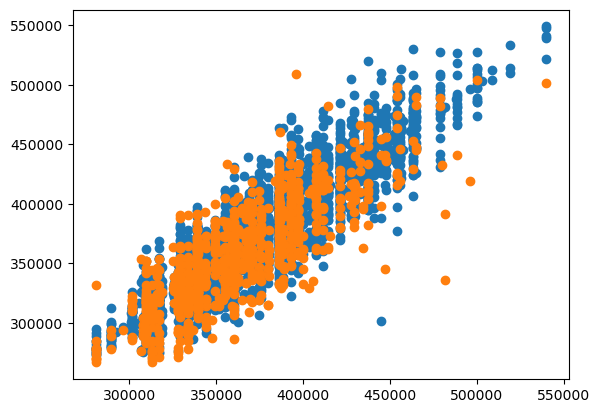

Raíz de la Pérdida cuadrática Entrenamiento: 20261.520278868604
Raíz de la Pérdida cuadrática Prueba: 25377.293954916506


In [33]:
# Prediccion utilizando los datos sumados de entrenamiento y validación y con la profundidad 3.

from matplotlib import pyplot as plt

# UUsando la mejor maxima profundidad

decision_tree_energia = DecisionTreeRegressor(max_depth=7)  # fill in best max depth here
decision_tree_energia.fit(train_val_feature, train_val_target)

# Prediciendo valores para entrenamiento y prueba 
train_val_prediction = decision_tree_energia.predict(train_val_feature)
test_prediction = decision_tree_energia.predict(test_feature)

# Comparación de los valores predichos vs los reales 
plt.scatter(train_val_prediction, train_val_target, label='train')  # blue
plt.scatter(test_prediction, test_target, label='test')  # orange
plt.show()
print("Raíz de la Pérdida cuadrática Entrenamiento:",sklearn.metrics.mean_squared_error( train_val_prediction, train_val_target,squared=False))

print("Raíz de la Pérdida cuadrática Prueba:",sklearn.metrics.mean_squared_error(test_prediction, test_target,squared=False))

In [34]:
from sklearn import tree

listacaract=list(df1_energia.columns.values)
respuesta=listacaract.pop()
text_representation = tree.export_text(decision_tree_energia)
print(text_representation)

|--- feature_2 <= 378270.00
|   |--- feature_2 <= 338762.00
|   |   |--- feature_2 <= 321435.00
|   |   |   |--- feature_1 <= 332431.00
|   |   |   |   |--- feature_2 <= 297257.50
|   |   |   |   |   |--- feature_1 <= 315517.00
|   |   |   |   |   |   |--- feature_2 <= 289017.50
|   |   |   |   |   |   |   |--- value: [313063.26]
|   |   |   |   |   |   |--- feature_2 >  289017.50
|   |   |   |   |   |   |   |--- value: [328045.52]
|   |   |   |   |   |--- feature_1 >  315517.00
|   |   |   |   |   |   |--- feature_0 <= 338394.00
|   |   |   |   |   |   |   |--- value: [280653.81]
|   |   |   |   |   |   |--- feature_0 >  338394.00
|   |   |   |   |   |   |   |--- value: [317416.82]
|   |   |   |   |--- feature_2 >  297257.50
|   |   |   |   |   |--- feature_0 <= 340450.00
|   |   |   |   |   |   |--- feature_1 <= 317565.50
|   |   |   |   |   |   |   |--- value: [333737.80]
|   |   |   |   |   |   |--- feature_1 >  317565.50
|   |   |   |   |   |   |   |--- value: [309884.16]
|   |   

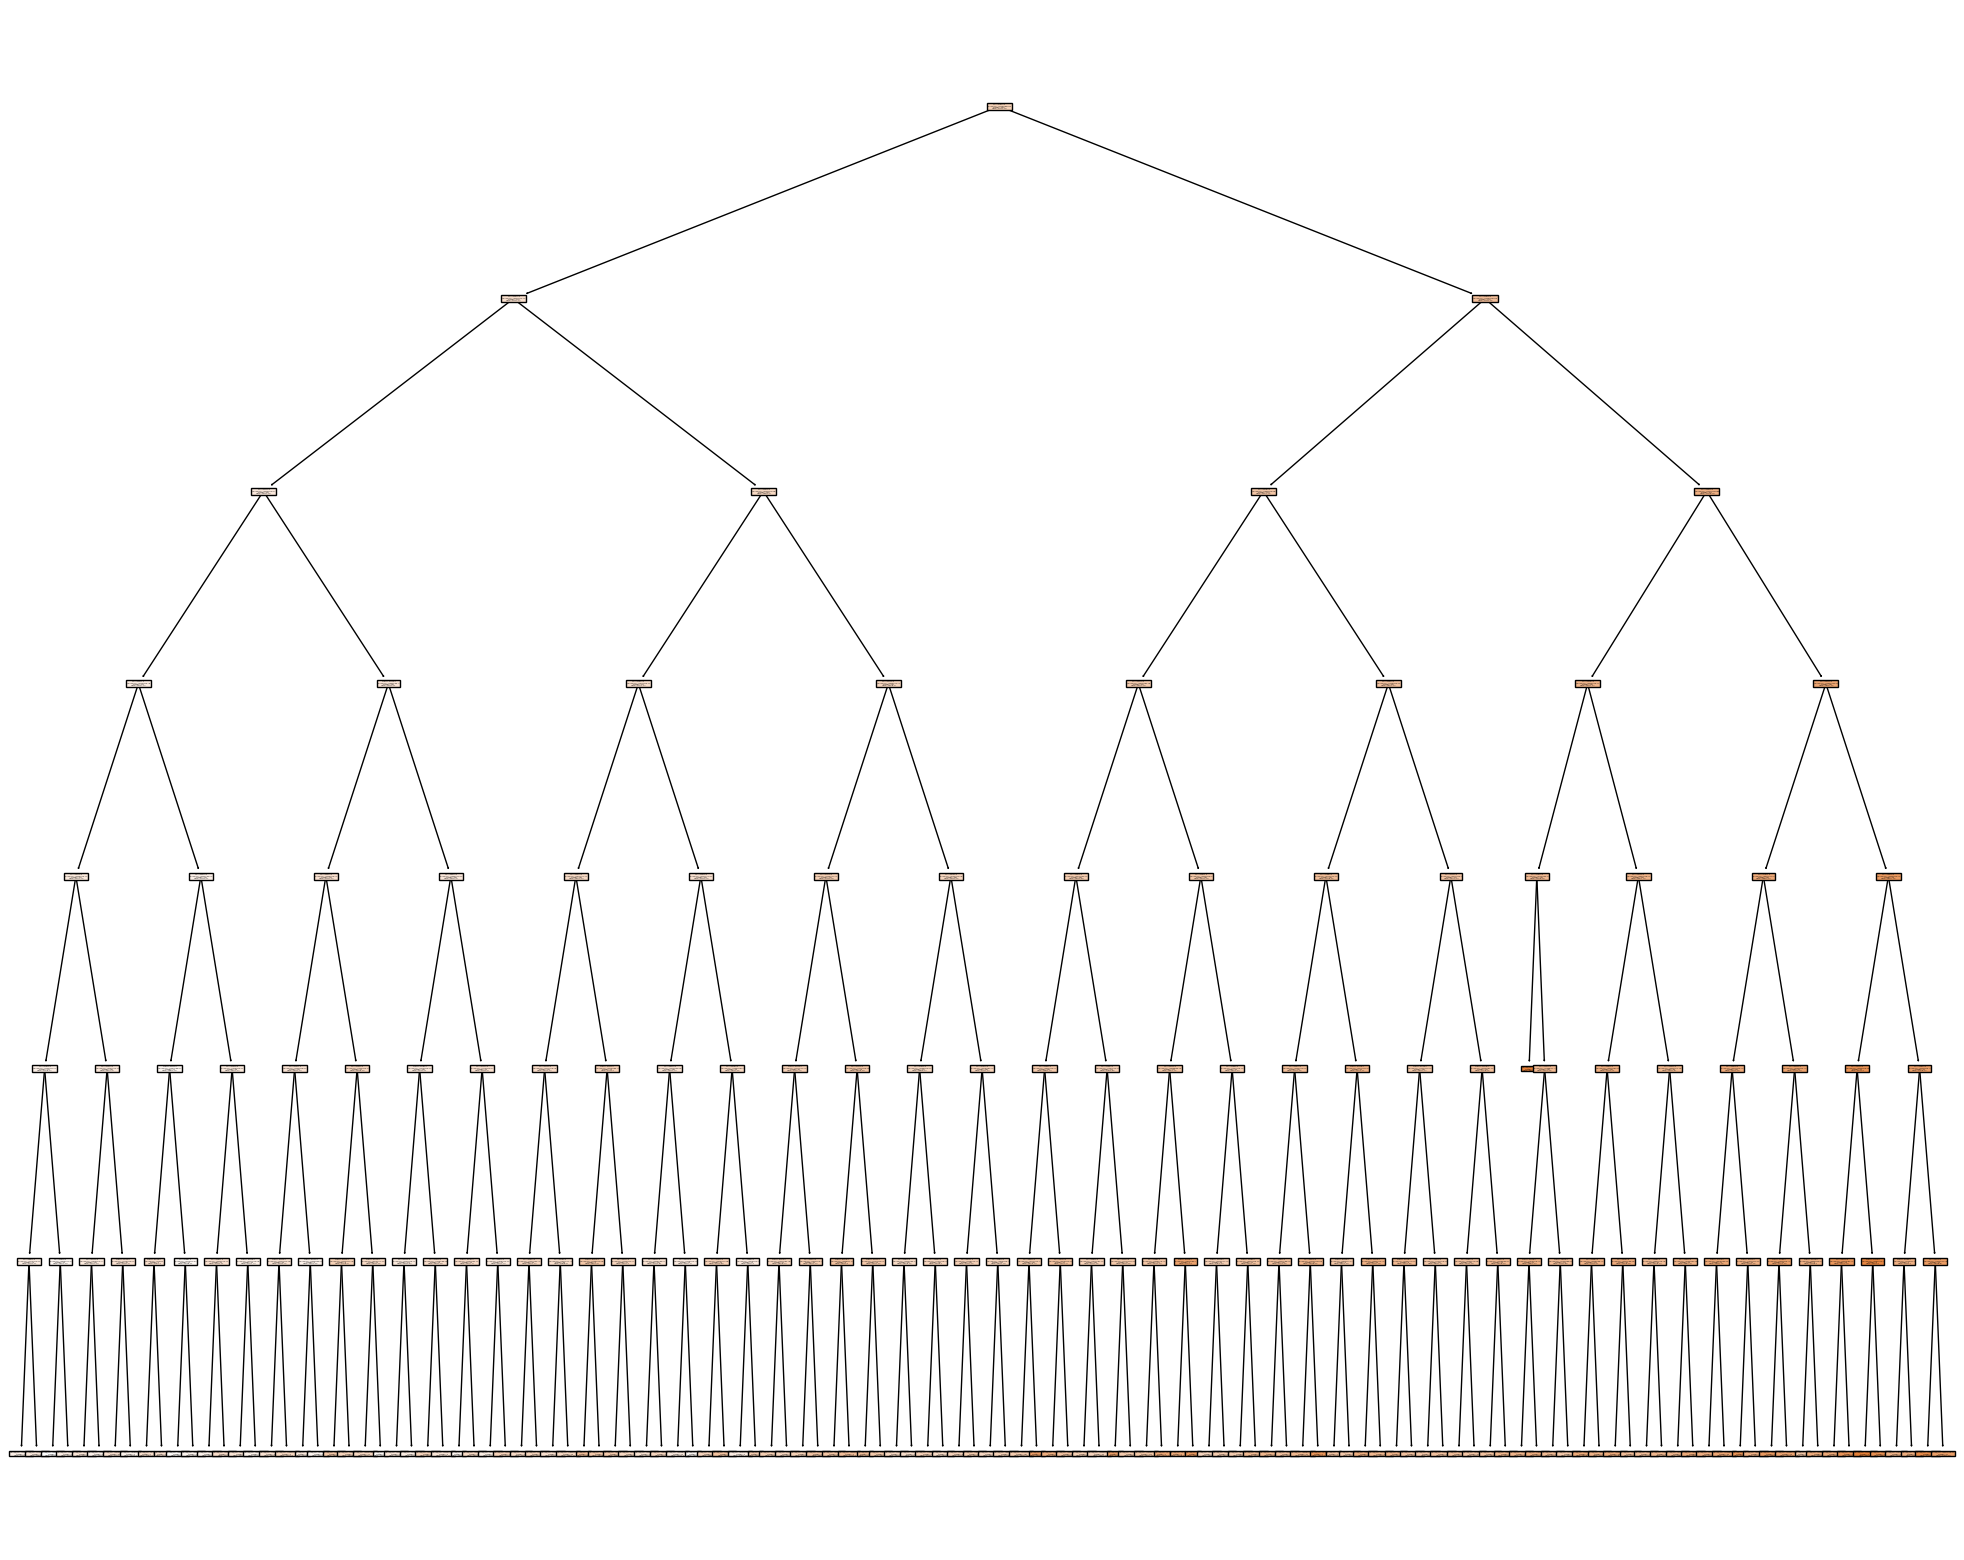

In [35]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(decision_tree_energia, 
                   feature_names=listacaract,  
                   class_names=respuesta,
                   filled=True)

In [36]:
print(train_val_prediction.size)
print(train_val_target.size)

print(test_prediction.size)
print(test_target.size)

3895
3895
974
974


In [37]:
indicetrian_val_test=df1_energia.index
print(indicetrian_val_test.size)  ###Tamaño del índice
indicetrain_val=indicetrian_val_test[0:3749]
indicetest=indicetrian_val_test[3749:4686]

4869


In [38]:
targetjoint=np.concatenate((train_val_target,test_target))
predictionjoint=np.concatenate((train_val_prediction,test_prediction))
print(targetjoint.size)
print(predictionjoint.size)

4869
4869


In [39]:
d = {'observado': targetjoint, 'Predicción': predictionjoint}
ObsvsPred=pd.DataFrame(data=d,index=indicetrian_val_test)
ObsvsPred.head(10)

,observado,Predicción
2004-07-04,347524.0,339514.170213
2004-07-05,346334.0,343884.933333
2004-07-06,337384.0,339192.451064
2004-07-07,338827.0,329151.507317
2004-07-08,338807.0,343884.933333
2004-07-09,310732.0,343884.933333
2004-07-10,287064.0,289630.250000
2004-07-11,321700.0,313063.260870
2004-07-12,334258.0,339514.170213
2004-07-13,346668.0,329151.507317


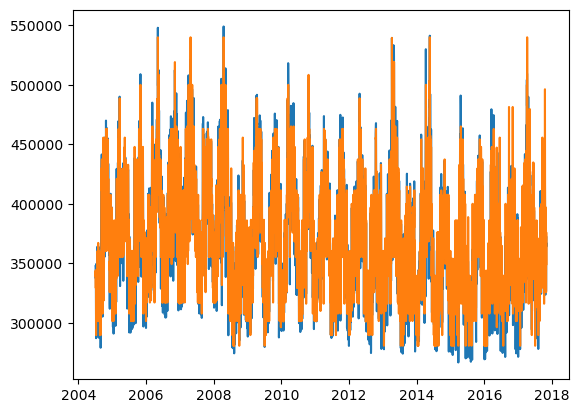

In [40]:
plt.plot(ObsvsPred)

# Redes neuronales

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.14.0
Pandas Version: 1.5.3
Numpy Version: 1.23.5
System Version: 3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]


In [10]:
import IPython
import IPython.display

In [11]:
df=energia
display(df.head())

,fecha,Energia
0,2004-10-01,254046
1,2004-10-02,318280
2,2004-10-03,293620
3,2004-10-04,333971
4,2004-10-05,347423


In [12]:
features_considered = ['Energia']

In [13]:
features = df[features_considered]
features.index = df['fecha']
features.head()

,Energia
fecha,
2004-10-01,254046
2004-10-02,318280
2004-10-03,293620
2004-10-04,333971
2004-10-05,347423


<Axes: xlabel='fecha'>

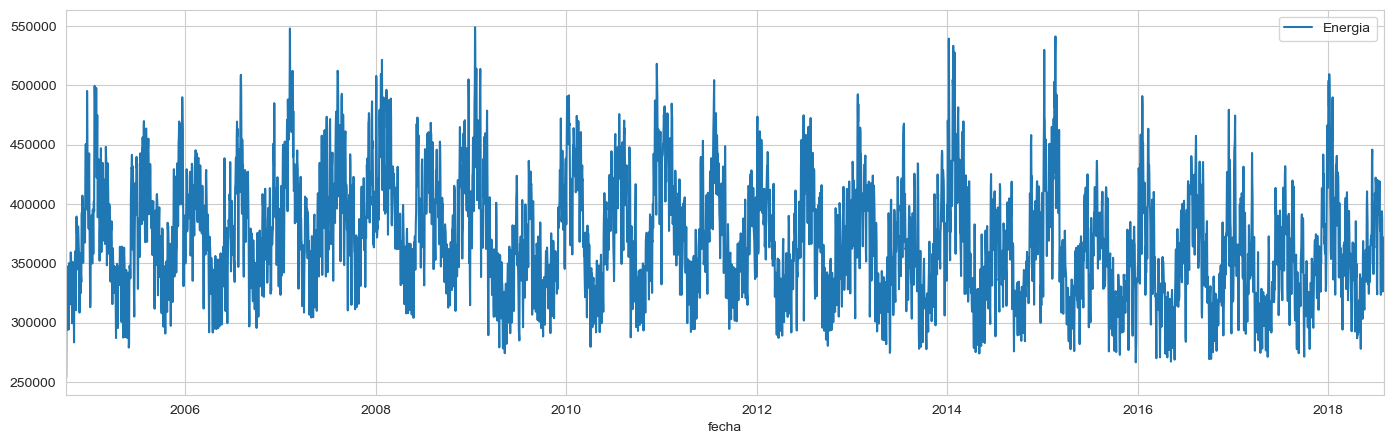

In [14]:
features.plot()

In [15]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [17]:
train_df

,Energia
fecha,
2004-10-01,-2.670644
2004-10-02,-1.297470
2004-10-03,-1.824644
2004-10-04,-0.962033
2004-10-05,-0.674461
...,...
2014-06-03,0.052573
2014-06-04,-0.307556
2014-06-05,-0.754734


In [18]:
print("longitud dataframe entrenamiento:",train_df.shape)
print("longitud dataframe validación:",val_df.shape)
print("longitud dataframe prueba:",test_df.shape)

longitud dataframe entrenamiento: (3537, 1)
longitud dataframe validación: (1011, 1)
longitud dataframe prueba: (506, 1)


# Window Generator

In [19]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


# Split

In [20]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Objetos a tensor flow

In [21]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=128,) ##### Tamaño del lote

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Definir las gráficas

In [23]:
def plot(self, model=None, plot_col='Energia', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# Configuración para el modelo de los ajustes

In [24]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Empezar

In [88]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Energia'])# La variable a predecir es T (degC)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Energia']

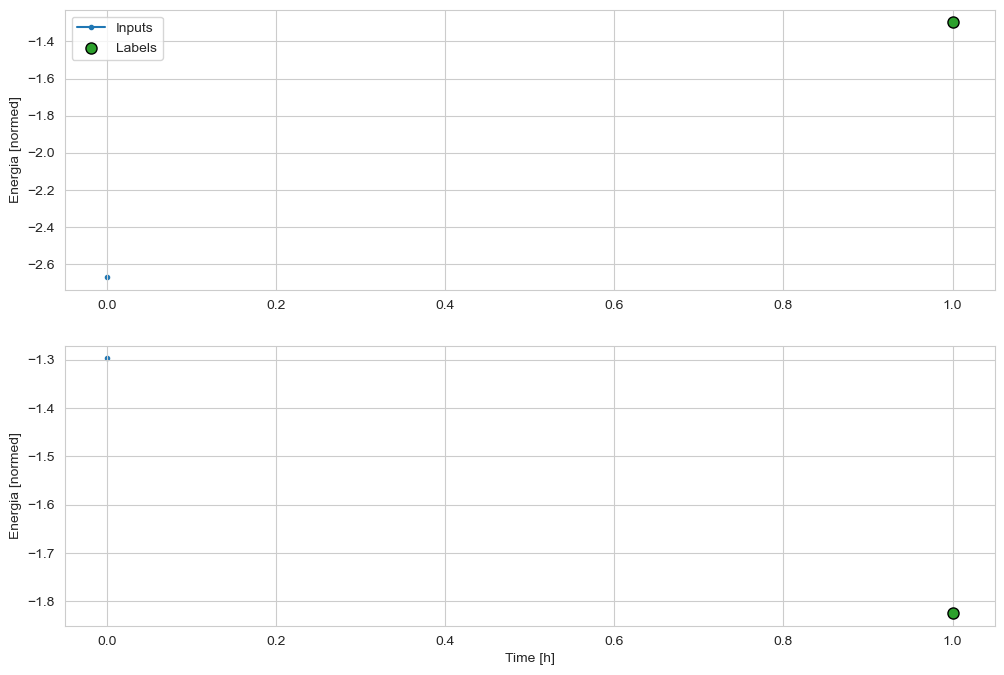

In [89]:
single_step_window.plot()

In [90]:
i=1
for batch in single_step_window.train.take(2):
    inputs, targets = batch
    print("Covariable o input del lote",i,inputs)
    print("Respuesta o etiqueta del lote ",i,targets)
    print("tipo de objeto inputs del lote",i,type(inputs))
    i=i+1

Covariable o input del lote 1 tf.Tensor(
[[[-2.6706438 ]]

 [[-1.2974703 ]]

 [[-1.8246437 ]]

 [[-0.9620333 ]]

 [[-0.67446077]]

 [[-0.6751235 ]]

 [[-0.70986223]]

 [[-0.69261044]]

 [[-1.338152  ]]

 [[-1.8115178 ]]

 [[-0.9485867 ]]

 [[-0.6164845 ]]

 [[-0.6851283 ]]

 [[-0.6690095 ]]

 [[-0.62644655]]

 [[-1.0188551 ]]

 [[-1.3571568 ]]

 [[-0.42218286]]

 [[-0.4265653 ]]

 [[-0.6395938 ]]

 [[-0.713924  ]]

 [[-0.69622326]]

 [[-1.2047126 ]]

 [[-1.6986223 ]]

 [[-0.8664323 ]]

 [[-0.595962  ]]

 [[-0.6682185 ]]

 [[-0.72439903]]

 [[-0.75580287]]

 [[-1.3297292 ]]

 [[-2.042525  ]]

 [[-0.9536318 ]]

 [[-0.63613063]]

 [[-0.60759145]]

 [[-0.42757004]]

 [[-0.39759853]]

 [[-0.78953683]]

 [[-1.4630618 ]]

 [[-0.64549404]]

 [[ 0.21495733]]

 [[ 0.22447039]]

 [[-0.08871253]]

 [[-0.078494  ]]

 [[-0.5909168 ]]

 [[-0.72662234]]

 [[ 0.02950601]]

 [[ 0.0448338 ]]

 [[-0.18360803]]

 [[-0.31954864]]

 [[-0.44747266]]

 [[-1.1320071 ]]

 [[-1.5063944 ]]

 [[-0.6318551 ]]

 [[-0

In [28]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [91]:
baseline = Baseline(label_index=column_indices['Energia'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 1s 32ms/step - loss: 0.2923 - mean_absolute_error: 0.4129


In [92]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,label_columns=['Energia'])


wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['Energia']

In [93]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (128, 30, 1)
Output shape: (128, 30, 1)


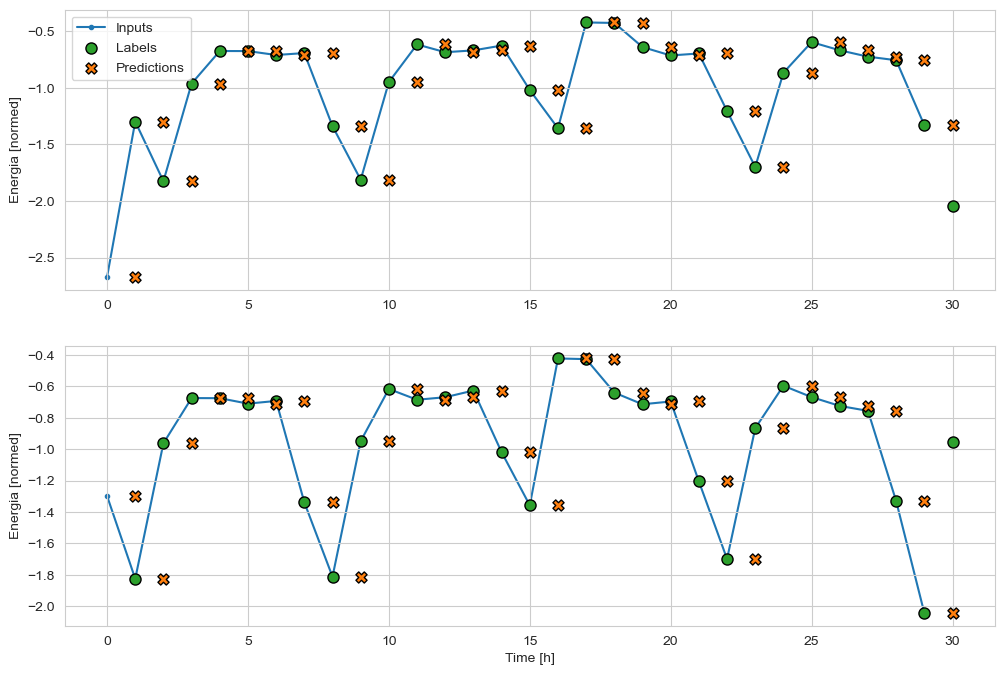

In [94]:
wide_window.plot(baseline)

# Multicapa

In [95]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
28/28 [==============================] - 12s 308ms/step - loss: 0.6120 - mean_absolute_error: 0.6235 - val_loss: 0.4035 - val_mean_absolute_error: 0.5195
Epoch 2/10
28/28 [==============================] - 2s 63ms/step - loss: 0.2989 - mean_absolute_error: 0.4299 - val_loss: 0.2782 - val_mean_absolute_error: 0.4125
Epoch 3/10
28/28 [==============================] - 4s 129ms/step - loss: 0.2847 - mean_absolute_error: 0.4216 - val_loss: 0.2763 - val_mean_absolute_error: 0.4131
Epoch 4/10
28/28 [==============================] - 2s 70ms/step - loss: 0.2847 - mean_absolute_error: 0.4214 - val_loss: 0.2768 - val_mean_absolute_error: 0.4131
Epoch 5/10
8/8 [==============================] - 1s 86ms/step - loss: 0.2769 - mean_absolute_error: 0.4135


## Tuning o búsqueda de los hiperparámetros

In [35]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

Using TensorFlow backend


In [96]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch
    

print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (128, 1, 1)
Target shape: (128, 1, 1)


In [97]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (128, 1, 1)
Target shape: (128, 1, 1)


In [98]:
single_step_window.train.element_spec

(TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [99]:
input_dataset_train = single_step_window.train.map(lambda x,y: x)
target_dataset_train = single_step_window.train.map(lambda x,y: y)

In [100]:
input_dataset_train

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>

In [101]:
input_dataset_val = single_step_window.val.map(lambda x,y: x)
target_dataset_val = single_step_window.val.map(lambda x,y: y)

In [102]:
print(input_dataset_val)
print(target_dataset_val)

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [103]:
input_dataset_test = single_step_window.test.map(lambda x,y: x)
target_dataset_test = single_step_window.test.map(lambda x,y: y)

In [104]:
print(input_dataset_test)
print(target_dataset_test)

<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>
<_MapDataset element_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None)>


In [105]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int("num_units", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=564, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"]
    )
    return model


build_model(kt.HyperParameters())

In [106]:
tuner_RandomSearch_mlp = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=1,
    overwrite=True,
    directory="dirsalida",
    project_name="helloworld",
)

In [107]:
tuner_RandomSearch_mlp.search_space_summary()

Search space summary
Default search space size: 6
num_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 564, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [108]:
stop_early=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=0)

In [109]:
tuner_RandomSearch_mlp.search((single_step_window.train), epochs=5, validation_data=(single_step_window.val),callbacks=[stop_early])


Trial 3 Complete [00h 00m 56s]
val_loss: 0.2706780731678009

Best val_loss So Far: 0.2706780731678009
Total elapsed time: 00h 02m 49s


In [110]:
# Get the top 2 models.
models_mlp = tuner_RandomSearch_mlp.get_best_models(num_models=2)
best_model_mlp = models_mlp[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model_mlp.build(input_shape=(128, 1, 1))
best_model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (128, 1, 256)             512       
                                                                 
 dense_1 (Dense)             (128, 1, 224)             57568     
                                                                 
 dense_2 (Dense)             (128, 1, 544)             122400    
                                                                 
 dense_3 (Dense)             (128, 1, 480)             261600    
                                                                 
 dropout (Dropout)           (128, 1, 480)             0         
                                                                 
 dense_4 (Dense)             (128, 1, 1)               481       
                                                                 
Total params: 442561 (1.69 MB)
Trainable params: 442561 

In [111]:
tuner_RandomSearch_mlp.results_summary()

Results summary
Results in dirsalida\helloworld
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
num_units: 256
activation: relu
num_layers: 3
units_0: 224
dropout: True
lr: 0.0003209523930194174
units_1: 544
units_2: 480
units_3: 128
Score: 0.2706780731678009

Trial 0 summary
Hyperparameters:
num_units: 320
activation: relu
num_layers: 3
units_0: 32
dropout: False
lr: 0.001106078991484569
units_1: 32
units_2: 32
Score: 0.27106109261512756

Trial 1 summary
Hyperparameters:
num_units: 192
activation: relu
num_layers: 4
units_0: 64
dropout: False
lr: 0.00022174390082042639
units_1: 384
units_2: 384
units_3: 32
Score: 0.2720114290714264


In [112]:
train_plus_val=single_step_window.train.concatenate(single_step_window.val)###verificar que en efecto

In [113]:
train_plus_val

<_ConcatenateDataset element_spec=(TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

In [114]:
# Get the top 2 hyperparameters.
best_hps_mlp = tuner_RandomSearch_mlp.get_best_hyperparameters(5)
# Build the model with the best hp.
callback=tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5)
model_mlp = build_model(best_hps_mlp[0])
# Fit with the entire dataset.
model_mlp.fit(train_plus_val, epochs=10,callbacks=[callback])

Epoch 1/10
36/36 [==============================] - 14s 73ms/step - loss: 0.4269 - mean_squared_error: 0.4269
Epoch 2/10
36/36 [==============================] - 3s 77ms/step - loss: 0.2973 - mean_squared_error: 0.2973
Epoch 3/10
36/36 [==============================] - 3s 73ms/step - loss: 0.2899 - mean_squared_error: 0.2899
Epoch 4/10
36/36 [==============================] - 3s 71ms/step - loss: 0.2894 - mean_squared_error: 0.2894
Epoch 5/10
36/36 [==============================] - 3s 71ms/step - loss: 0.2899 - mean_squared_error: 0.2899
Epoch 6/10
36/36 [==============================] - 3s 76ms/step - loss: 0.2900 - mean_squared_error: 0.2900
Epoch 7/10
36/36 [==============================] - 3s 74ms/step - loss: 0.2883 - mean_squared_error: 0.2883
Epoch 8/10
36/36 [==============================] - 3s 86ms/step - loss: 0.2866 - mean_squared_error: 0.2866
Epoch 9/10
36/36 [==============================] - 3s 66ms/step - loss: 0.2874 - mean_squared_error: 0.2874
Epoch 10/10
36/36 

In [115]:
print(model_mlp.layers[0].weights)

[<tf.Variable 'dense_5/kernel:0' shape=(1, 256) dtype=float32, numpy=
array([[ 1.16332799e-01,  8.52219537e-02,  1.36082798e-01,
         6.20533414e-02, -3.89221236e-02, -1.07784957e-01,
        -3.37821282e-02, -4.61823121e-03, -1.41100675e-01,
        -1.27330452e-01, -1.47391230e-01, -1.01457395e-01,
        -8.48561674e-02, -1.17161140e-01, -9.38535407e-02,
        -1.58757239e-03,  4.66800034e-02, -1.02817856e-01,
        -3.62341180e-02, -1.68333314e-02, -1.33946806e-01,
        -1.34968430e-01, -4.52081338e-02, -5.71841449e-02,
         5.91158420e-02, -7.68721569e-03, -1.26328334e-01,
         4.10915874e-02, -1.04341984e-01, -1.56437494e-02,
         1.01257369e-01, -2.71685813e-02,  1.88056603e-02,
         1.39802620e-01, -9.55408514e-02, -1.34112820e-01,
         1.32358134e-01,  1.06760912e-01,  7.86801949e-02,
        -3.42688113e-02,  1.27214029e-01, -1.16763629e-01,
         1.36674523e-01,  6.15374818e-02,  2.15895902e-02,
         1.50667056e-01, -6.47497410e-03, -1.

In [116]:
print(model_mlp.layers[0].bias.numpy())

[-9.66126192e-03  2.66757142e-03  2.77187675e-03  1.06269913e-03
 -1.37352133e-02 -3.70449782e-03  6.13196520e-03  5.74597297e-03
  9.23714659e-04  9.85274557e-04 -7.72527477e-04 -2.38693133e-03
  4.86050220e-03 -1.68798473e-02  2.00131023e-03 -4.39553428e-03
  5.08942828e-03 -1.34219509e-02 -2.10683513e-03 -7.33952131e-03
  1.59150234e-03 -1.03393635e-02 -9.66659468e-03  3.78149678e-03
  1.01827532e-02  7.06223364e-04  2.73951911e-03  1.41806318e-03
  1.47883908e-03 -1.64707769e-02  3.49217560e-03 -3.97615042e-03
 -5.44939842e-03 -1.79550343e-03  2.84370524e-03 -1.06597403e-02
  1.55715737e-03  7.72480736e-04 -7.20409444e-05 -2.97932047e-03
  2.59622373e-03  2.66791275e-03 -1.04953520e-04  2.11566407e-03
  1.39239582e-03  1.05276774e-03  5.37634222e-03  4.86589456e-03
  4.39923350e-03 -1.24189360e-02  3.90774570e-03 -3.07673449e-03
 -6.81285455e-04  2.94854515e-03  9.40340047e-04  1.72023627e-03
  3.80553282e-03  5.32861624e-04 -3.79437045e-03  5.25058061e-03
  3.46997404e-03  4.37142

In [117]:
model_mlp.evaluate(single_step_window.test, verbose=1)

4/4 [==============================] - 2s 67ms/step - loss: 0.2286 - mean_squared_error: 0.2286


[0.22859707474708557, 0.22859707474708557]

In [118]:
model_mlp.predict(single_step_window.test).flatten()

4/4 [==============================] - 2s 51ms/step


array([ 1.0529567 ,  0.6752413 ,  0.4560266 , -0.67811173, -1.0624278 ,
       -0.43602458, -0.80909884, -0.69731385, -0.22977614, -0.89846617,
       -1.735342  , -1.8961722 , -1.3510035 , -1.1734338 , -1.1245232 ,
       -1.0768256 , -1.1250274 , -1.4059615 , -1.6366152 , -1.2905042 ,
       -1.1661417 , -1.1585305 , -1.0781021 , -0.48506987, -1.1759374 ,
       -1.7491391 , -1.378882  , -1.2271659 , -1.2680142 , -1.2908064 ,
       -1.5550421 , -1.8555534 , -1.9253438 , -1.4336728 , -1.2612286 ,
       -1.2245958 , -1.0197766 , -1.1630838 , -1.6623963 , -1.865809  ,
       -1.3331158 , -1.2183287 , -1.1230785 , -1.0671823 , -1.2736241 ,
       -1.4874675 , -1.5461631 , -1.1263547 , -1.4030913 , -1.4350994 ,
       -1.3599558 , -1.2674096 , -1.6630174 , -1.8909688 , -1.2811991 ,
       -1.1536243 , -1.2027364 , -1.1050835 , -1.3136659 , -1.7240967 ,
       -1.9817902 , -1.3049488 , -0.9194941 , -0.38713774, -0.21922171,
       -0.45234203, -1.2674599 , -1.6044728 , -1.2689211 , -1.19

In [119]:
prediction_test=(model_mlp.predict(single_step_window.test, verbose=1)*train_std['Energia']+train_mean['Energia'])

4/4 [==============================] - 1s 48ms/step


In [120]:
print(prediction_test.shape)
print(prediction_test)

(505, 1, 1)
[[[428227.75]]

 [[410559.06]]

 [[400304.7 ]]

 [[347252.22]]

 [[329274.78]]

 [[358576.53]]

 [[341124.94]]

 [[346354.  ]]

 [[368224.38]]

 [[336944.53]]

 [[297797.34]]

 [[290274.06]]

 [[315775.84]]

 [[324082.16]]

 [[326370.1 ]]

 [[328601.28]]

 [[326346.5 ]]

 [[313205.03]]

 [[302415.56]]

 [[318605.88]]

 [[324423.25]]

 [[324779.3 ]]

 [[328541.56]]

 [[356282.28]]

 [[323965.06]]

 [[297151.94]]

 [[314471.75]]

 [[321568.7 ]]

 [[319657.9 ]]

 [[318591.72]]

 [[306231.38]]

 [[292174.12]]

 [[288909.5 ]]

 [[311908.75]]

 [[319975.3 ]]

 [[321688.9 ]]

 [[331269.9 ]]

 [[324566.3 ]]

 [[301209.6 ]]

 [[291694.38]]

 [[316612.6 ]]

 [[321982.06]]

 [[326437.7 ]]

 [[329052.38]]

 [[319395.5 ]]

 [[309392.38]]

 [[306646.72]]

 [[326284.4 ]]

 [[313339.3 ]]

 [[311842.03]]

 [[315357.06]]

 [[319686.2 ]]

 [[301180.53]]

 [[290517.47]]

 [[319041.12]]

 [[325008.8 ]]

 [[322711.44]]

 [[327279.44]]

 [[317522.4 ]]

 [[298323.38]]

 [[286269.06]]

 [[317930.2 

In [121]:
i=1
for batch in target_dataset_test.take(4): # pongo 4 porque me slaieron 4 lotes
    if i==1:
        targets_test = batch.numpy()
    elif i>1:
        targets_test_aux = batch.numpy()
        targets_test=np.append(targets_test,targets_test_aux)
    i=i+1

In [122]:
print(targets_test.shape)
true_series=targets_test*train_std['Energia']+train_mean['Energia']
true_series=true_series.reshape((505,1,1))
print(true_series.shape)

(505,)
(505, 1, 1)


In [123]:
errors_squared=tf.keras.metrics.mean_squared_error(true_series, prediction_test).numpy()
print("RECM:",errors_squared.mean()**0.5)

RECM: 22365.3081355925


In [124]:
test_index=test_df.index[:499]
test_index.values

array(['2017-03-15T00:00:00.000000000', '2017-03-16T00:00:00.000000000',
       '2017-03-17T00:00:00.000000000', '2017-03-18T00:00:00.000000000',
       '2017-03-19T00:00:00.000000000', '2017-03-20T00:00:00.000000000',
       '2017-03-21T00:00:00.000000000', '2017-03-22T00:00:00.000000000',
       '2017-03-23T00:00:00.000000000', '2017-03-24T00:00:00.000000000',
       '2017-03-25T00:00:00.000000000', '2017-03-26T00:00:00.000000000',
       '2017-03-27T00:00:00.000000000', '2017-03-28T00:00:00.000000000',
       '2017-03-29T00:00:00.000000000', '2017-03-30T00:00:00.000000000',
       '2017-03-31T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-04-02T00:00:00.000000000', '2017-04-03T00:00:00.000000000',
       '2017-04-04T00:00:00.000000000', '2017-04-05T00:00:00.000000000',
       '2017-04-06T00:00:00.000000000', '2017-04-07T00:00:00.000000000',
       '2017-04-08T00:00:00.000000000', '2017-04-09T00:00:00.000000000',
       '2017-04-10T00:00:00.000000000', '2017-04-11

In [125]:
true_series_final=true_series.reshape(505)
prediction_test_final=prediction_test.reshape(505)

Text(0, 0.5, 'Y y $\\hat{Y}$ en conjunto de prueba')

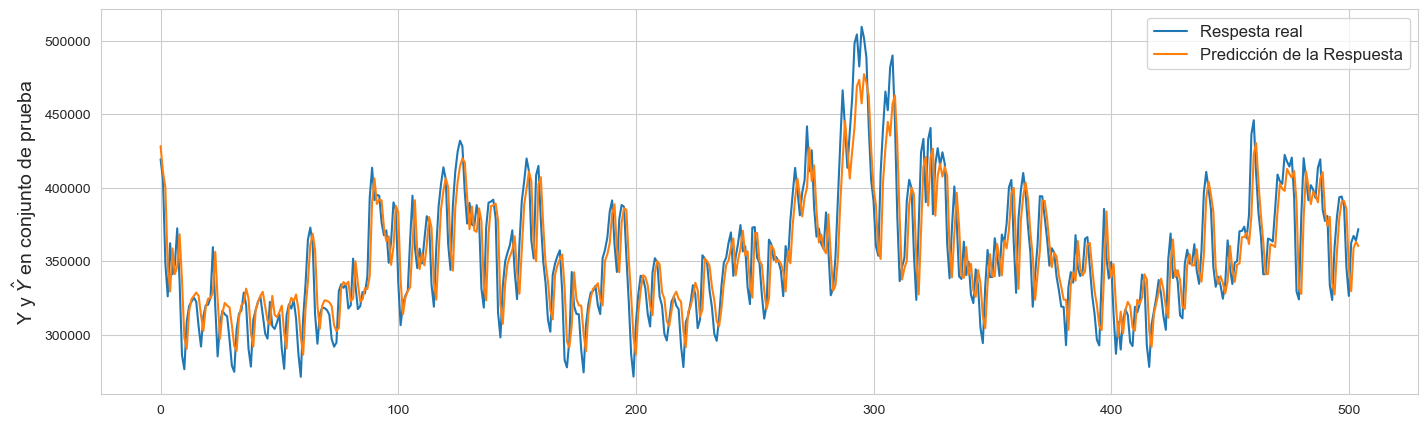

In [126]:
plt.plot(true_series_final)
plt.plot(prediction_test_final)
plt.legend(['Respesta real','Predicción de la Respuesta'],loc="best", fontsize=12)
plt.ylabel('Y y $\hat{Y}$ en conjunto de prueba', fontsize=14)